# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [99]:
!pip install nltk

In [100]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score # to report on precision and recall
import numpy as np
import re

In [101]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [102]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    """ Returns a tuple of the label as just FAKE or REAL and the statement """

    # Converts the labels given in data to 'FAKE' or 'REAL'
    label = convert_label(data_line[1].lower())
    text = data_line[2]
    return (label, text)

In [103]:

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS

    # separates punctuation from the start of the array
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)

    # separates punctuation from the end of the array
    text = re.sub(r"([.,;:!?'\"”\)])(\w)", r"\1 \2", text)

    # splits the text into tokens
    tokens = re.split('\s+', text)

    # converts the tokens to lowercase
    tokens = [t.lower() for t in tokens]
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [104]:
def to_feature_vector(tokens, training = False):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    feature_vector = {}   # initializing the feature_vector

    for t in tokens:
        # First add to the global feature dictionary, and give it a position
        # if in training
        try:
            # increasing the count if the token already exists
            feature_vector[t] += 1

        except KeyError:
            # inserting a new token
            feature_vector[t] = 1

    return feature_vector

In [105]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [106]:
#solution
from sklearn.metrics import classification_report

# Initializing cv_results dictionary and defining its keys
cv_results = {}
cv_results.fromkeys(['precision', 'recall', 'fscore', 'accuracy'])

def cross_validate(dataset, folds):

    """This method evaluates a model using the given data by using the k-fold cross validation"""

    # Initializing lists to store computed values
    precision = []
    recall = []
    fscore = []
    support = []
    accuracy = []

    # Calculating the fold size
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

        # Diving the given data into training and validation data
        training_data = dataset[0:i] + dataset[(i + fold_size):len(dataset)]
        val_data = dataset[i:(i + fold_size)]

        # Training a model with training data
        classifier = train_classifier(training_data)

        # predicting the labels using validation data
        val_to_pred = [(d) for (d, s) in val_data]
        val_pred = predict_labels(val_to_pred, classifier)

        # separating the labels from the text and storing them in a list
        val_true = [t[1] for t in val_data]

        # calculating the metrics
        p, r, f, s = precision_recall_fscore_support(val_true, val_pred, average='weighted')
        a = accuracy_score(val_true, val_pred)

        # Storing metrics of the current fold in lists
        precision.append(p)
        recall.append(r)
        fscore.append(f)
        accuracy.append(a)

    # Storing the overall metrics in cv_results dictionary
    cv_results['precsion'] = sum(precision)/len(precision)
    cv_results['recall'] = sum(recall)/len(recall)
    cv_results['fscore'] = sum(fscore)/len(fscore)
    cv_results['accuracy'] = sum(accuracy)/len(accuracy)

    # Printing results
    print(cv_results)

    return None


In [107]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

In [108]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
1


In [109]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...


/Users/nitishsadhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold start on items 3280 - 4100
Training Classifier...


/Users/nitishsadhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...


/Users/nitishsadhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...
{'precsion': 0.5647503173267673, 'recall': 0.5641409347591013, 'fscore': 0.5639767858573375, 'accuracy': 0.5641409347591013}


# 4. Error Analysis (10 marks)

In [110]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels = labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


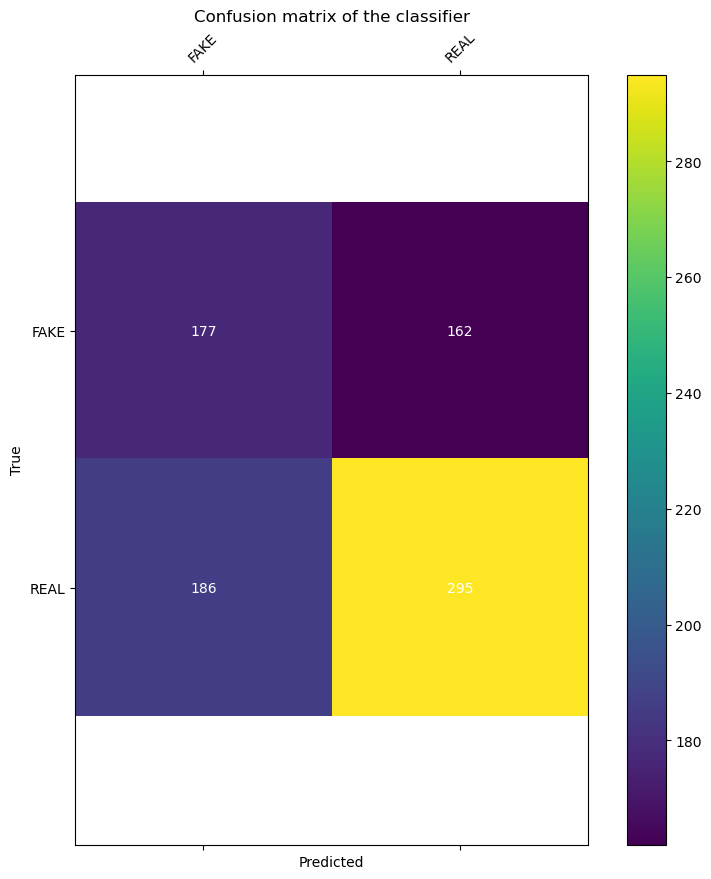

In [111]:
# ERROR ANALYSIS USING THE FIRST FOLD

# Computing fold size
fold_size = int(len(train_data)/10) + 1

# Splitting training data and testing data
training_data = train_data[fold_size : len(train_data)]
testing_data = train_data[0 : fold_size]

# Getting labels to a list for validation
test_true = [l for (d, l) in testing_data]

# Predicting from test data
test_to_pred = [(d) for (d, s) in testing_data]
test_pred = predict_labels(test_to_pred, train_classifier(training_data))

# Initializing lists to store false_positive and false_negatives of FAKE label
false_positive_fake = []
false_negative_fake = []

# Writing false_positives to a list
for i in range(0, len(test_pred)):
    if (test_true[i] == 'REAL') & (test_pred[i] == 'FAKE'):
        false_positive_fake.append(testing_data[i])

# Writing false_negatives to a list
for i in range(0, len(test_pred)):
    if (test_true[i] == 'FAKE') & (test_pred[i] == 'REAL'):
        false_negative_fake.append(testing_data[i])

# Writing the false_positive_fake list to a file
with open('false_positive_fake.csv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output)
    tsv_output.writerow(false_positive_fake)

# Writing the false_negative_fake list to a file
with open('false_negative_fake.csv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output)
    tsv_output.writerow(false_negative_fake)

# Plotting a heat map using confusion_matrix_heatmap method
confusion_matrix_heatmap(test_true, test_pred, labels = ['FAKE', 'REAL'])

# Questions 5 (20%) and 6 (20%) (recommend starting a new notebook)

In [112]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'the': 2, 'bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, '.': 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.565031
Recall: 0.565154
F Score:0.565091


/Users/nitishsadhu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [113]:
train_data

[({'says': 1,
   'the': 1,
   'annies': 1,
   'list': 1,
   'political': 1,
   'group': 1,
   'supports': 1,
   'third-trimester': 1,
   'abortions': 1,
   'on': 1,
   'demand': 1,
   '.': 1},
  'FAKE'),
 ({'when': 2,
   'did': 1,
   'the': 1,
   'decline': 1,
   'of': 1,
   'coal': 1,
   'start': 1,
   '?': 1,
   'it': 1,
   'started': 2,
   'natural': 1,
   'gas': 1,
   'took': 1,
   'off': 1,
   'that': 1,
   'to': 1,
   'begin': 1,
   'in': 1,
   '(president': 1,
   'george': 1,
   'w': 1,
   '.)': 1,
   'bushs': 1,
   'administration': 1,
   '.': 1},
  'REAL'),
 ({'hillary': 1,
   'clinton': 1,
   'agrees': 1,
   'with': 1,
   'john': 1,
   'mccain': 1,
   '"': 1,
   'by': 1,
   'voting': 1,
   'to': 1,
   'give': 1,
   'george': 1,
   'bush': 1,
   'the': 2,
   'benefit': 1,
   'of': 1,
   'doubt': 1,
   'on': 1,
   'iran': 1,
   '."': 1},
  'REAL'),
 ({'health': 1,
   'care': 1,
   'reform': 1,
   'legislation': 1,
   'is': 1,
   'likely': 1,
   'to': 1,
   'mandate': 1,
   'fre